# Efficient Graph Based Image Segmentation (Code)

Here, we are trying to implement the algorithm proposed in [Efficient Graph-Based Image Segmentation](http://cs.brown.edu/%7Epff/segment) (EGBIseg)
which was developed by Felzenszald et al. in 2003.

In [107]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from scipy.signal import convolve2d
from matplotlib.ticker import NullFormatter  # useful for `logit` scal



When the libraries are ready, we are going to open the image which will be used for the segmentation.
The image are in the dataset folder (you may find 2) the vis.jpg is a visible image, and vis_nir.jpg is an image captured with a single sensor camera (it contains visible and near infrared spectrums)

(256, 256)


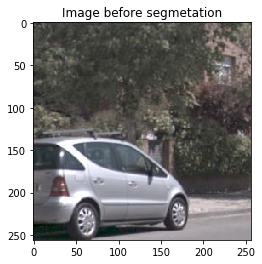

In [108]:
%matplotlib inline
img_name = 'dataset/vis.jpg'  # 'dataset/vis_nir.jpg'
img = Image.open(img_name)
img.load()
plt.title("Image before segmetation")
plt.imshow(img)
plt.draw()
print (img.size)

According to Graph-Based Segmentation we need to make a Graph however, before such a step it is necessary to split the image channels and make a convolution (with gaussina filter) to each channels, Therefore, and for the purpose of the algorithm implementation it is necessary to define some parameters:
**kernel**, **sigma**, etc.

**Kernel:** 
**Sigma:**

**Image size:** the image used is 256x256x3 (width x heigth, depth)


In [120]:
neighbor = 10
sigma = 0.8
kernel = 3
min_size = 256
img_size = img.size[0]


Bellow you could find two function gaussian_filter and img_convolution. The first one is to make a grid which will contain the gaussian distribution to then apply img_convolution to each channel in order to compensate for digitalization artifacts.
 
 To calculate the gaussian filter we refer to:
 
 ![gaussian formula](https://homepages.inf.ed.ac.uk/rbf/HIPR2/eqns/eqngaus2.gif)

In [121]:
def gaussian_filter(kernel_size, sigma):
    mi = (np.int(np.float(kernel_size)/2))
    ma = mi+1
    x,y = np.mgrid[-mi:ma,-mi:ma]
#     g_filter = np.exp(mi**2) * np.exp(-sigma*(x**2 + y **2))
    g_filter = (1/(2*np.pi*sigma**2)) * np.exp(-(x**2 + y **2)/(2*sigma**2))
    return g_filter/g_filter.sum(), x, y
    
    
# image convolution
def img_convolution(channel, gaussian_kernel):
    channel = convolve2d(channel,gaussian_kernel, mode='same')
    return channel

kernel before process:
[[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]]
[[-1  0  1]
 [-1  0  1]
 [-1  0  1]]
[[ 0.05711826  0.12475775  0.05711826]
 [ 0.12475775  0.27249597  0.12475775]
 [ 0.05711826  0.12475775  0.05711826]]


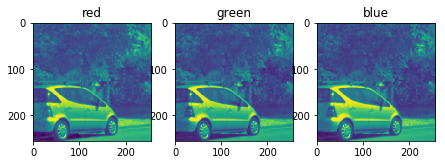

In [122]:

r,g,b = img.split()
r = np.float32(np.asarray(r)) 
g = np.float32(np.asarray(g)) 
b = np.float32(np.asarray(b)) 
gaussian_kernel, x, y = gaussian_filter(kernel, sigma)

r = img_convolution(r,gaussian_kernel)
g = img_convolution(g, gaussian_kernel)
b = img_convolution(b,gaussian_kernel)
img_group = (r,g,b)

print("kernel before process:")
print(x)
print(y)
print(gaussian_kernel)

fig = plt.figure()
sub_fig = fig.add_subplot(1,3,1)
img_plot = plt.imshow(r)
sub_fig.set_title('red')
sub_fig = fig.add_subplot(1,3,2)
img_plot = plt.imshow(g)
sub_fig.set_title('green')
sub_fig = fig.add_subplot(1,3,3)
img_plot = plt.imshow(b)
# img_plot.set_clim(0.0,0.7)
sub_fig.set_title('blue')
plt.gca().yaxis.set_minor_formatter(NullFormatter())
plt.subplots_adjust(top=0.97,bottom=0.08, left=0.02, right=0.95, hspace=0.75)
plt.draw()



Well, We are ready to start coding whole of process needed to make a graph G = (V,E).Therefore, bellow we are developing some usefull fucntion to get our graph and then  compute the segmentation.

In the pag. 4 of the paper [EGBIseg](http://cs.brown.edu/%7Epff/segment) (section III) mention the dissimilarity computing and one the the dissimilarity measurer is Euclidean distance calculing.




In [127]:
def euclidean_distance(img_group, x1,x2,y1,y2):
#     For the weight of the edge. Some measure of the dissimilarity between
#     the two pixels conected be that edge
    r = (img_group[0][x1,y1] - img_group[0][x2,y2])**2
    g = (img_group[1][x1,y1] - img_group[1][x2,y2])**2
    b = (img_group[2][x1,y1] - img_group[2][x2,y2])**2
    return np.sqrt(r+g+b)

def create_edges(img, img_size, x,y,x2,y2, eu_dis):
    vertex = lambda x,y: y*img_size+x
    w_edge = eu_dis(img, x,y,x2,y2)
    
    return (vertex(x,y), vertex(x2,y2), w_edge)

def build_graph(img,img_size, eu_dis, neighborhood_8=False):
    graph=[]
    for y in range(img_size):
        for x in range(img_size):
            if x>0:
                graph.append(create_edges(img, img_size, x,y, x-1, y, eu_dis))
            if y>0:
                graph.append(create_edges(img,img_size, x,y,x,y-1, eu_dis))
            if neighborhood_8:
                
                if x > 0 and y > 0:
                    graph.append(create_edge(img, img_size, y, x-1, y-1, eu_dis))

                if x > 0 and y < img_size-1:
                    graph.append(create_edge(img, img_sizey, x-1, y+1, eu_dis))
                
    return graph
    

In [129]:
eu_dis = euclidean_distance
graph = build_graph(img_group,img_size, eu_dis, neighbor==8)

print(graph[1])


(2, 1, 76.913343186734849)
